<b>Sean Lahman's Baseball Dataset Salaries & Team Performance Analysis</b>

Using Sean Lahman's baseball dataset, we will analyse the relationship between the average team salary and the team performance. We are interested in exploring how the average team salary increases over time and if teams that have  higher salaires tend to have a better performance. First, we will load the necessary tables:

In [421]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#Loading baseball teams and salaries datasets
teams_df = pd.read_csv('Teams.csv')
salaries_df = pd.read_csv('Salaries.csv')

## Questions to explore in the data:
## How has average team salary increase over time?
## Is average team salary related to the team performance?

The salary dataset contains information about the wage of each player for several years. When anlysing change in salary over time it is important to take into consideration the inflation, so that we can verify if salaries have actually improved.

In the code below we are going to load the Consumer Price Index (CPI) data so that we can consider inflation effects in our work. The data was downloaded from this website: https://fred.stlouisfed.org/series/CPIAUCSL/downloaddata The CPI data is yearly but it's date field format includes the month and day, in the code below we will create a yearID field with just the year so that we can easily join it with the salaries table.

In [422]:
#Loading Consumer Price Index (CPI) dataset to measure inflation
cpi_df = pd.read_csv('CPIAUCSL.csv')

#This function will convert a date to a year
def split_date_to_year(x):
    return x.split('-')[0]

#Treating CPI dataset and calculating inflation factors to 2015

#Creating a yearID field to be used later on to join with the salary table
cpi_df['yearID'] = pd.DataFrame(cpi_df['DATE'].apply(split_date_to_year), dtype = 'int64')
#Getting the CPI value for 2015
cpi_2015 = pd.to_numeric(cpi_df.iloc[cpi_df.shape[0]-2:cpi_df.shape[0]-1]['VALUE'], errors='coerce')[cpi_df.shape[0]-2]
#Calculating inflation in relation to 2015
cpi_df['cpi_to_2015'] = cpi_2015/pd.to_numeric(cpi_df['VALUE'], errors='coerce')

#Adjusting salary values to 2015 dollars using inflation (CPI) data
merged_salary_cpi = pd.merge(salaries_df, cpi_df, how='inner', on=['yearID'])
salaries_df['adj_salary'] = merged_salary_cpi['salary']*merged_salary_cpi['cpi_to_2015']

Now that we calculated adjusted salaries to 2015 dollars, lets take a look at the salaries_df data frame:

In [423]:
#Printing salaries statisticts    
print salaries_df.describe()

             yearID        salary    adj_salary
count  25575.000000  2.557500e+04  2.557500e+04
mean    2000.374389  2.008563e+06  2.487850e+06
std        8.610604  3.315706e+06  3.743759e+06
min     1985.000000  0.000000e+00  0.000000e+00
25%     1993.000000  2.750000e+05  3.888147e+05
50%     2000.000000  5.500000e+05  8.121919e+05
75%     2008.000000  2.250000e+06  3.037477e+06
max     2015.000000  3.300000e+07  3.644972e+07


Using the describe function, we can see that there is a great variability in salary values. They can vary from zero to about 4 Million Dollars a year! Below we will plot the average team salary per year. We are going to compare the salary with the inflation-adjusted values.

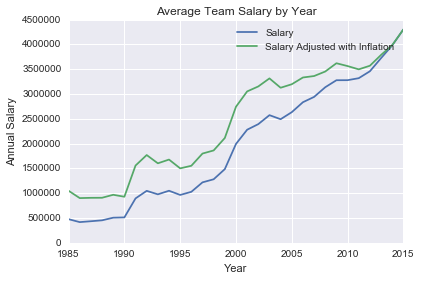

In [424]:
%matplotlib inline

plot_salary = salaries_df.groupby(['yearID'])['salary', 'adj_salary'].mean()
plot = plot_salary.plot(kind='line', subplots=False, title='Average Team Salary by Year')
plot.set_xlabel('Year')
plot.set_ylabel('Annual Salary')
plot.legend(plot.get_legend_handles_labels()[0],['Salary', 'Salary Adjusted with Inflation'])

The graph above shows that there has in fact been a significant growth in salaries for baseball players since 1985.

We will continue this analysis by trying to see if there is a relationship between the team's average salary and its performance. However, it is necessary that we standardize the salary data for each year so that we can make a better comparison. For example, a salary of 1 Million Dollars on 1985 was considered on average but below average on 2015.

In [425]:
#This function will standardize a panda series
def standardize(x):
    return (x - x.mean())/x.std(ddof=0)

#Standardizing salaries for each year
salaries_year_mean = pd.DataFrame(salaries_df.groupby(['yearID'])['adj_salary'].mean())
salaries_year_std = pd.DataFrame(salaries_df.groupby(['yearID'])['adj_salary'].std(ddof=0))
salaries_df = salaries_df.join(salaries_year_mean, on=['yearID'], rsuffix='_year_mean')\
.join(salaries_year_std, on=['yearID'], rsuffix='_year_std')
salaries_df['std_salary_year'] = (salaries_df['adj_salary']-salaries_df['adj_salary_year_mean'])/\
salaries_df['adj_salary_year_std']

To compare each team's performance we need to define a performance metric. The teams_df data frame provides us with wins and losses information for each team in each year, we will use as our performance metric the standardized ratio between wins and losses.

In [426]:
#Creating performance metrics based on wins and losses
teams_df['win_loss_ratio'] = pd.DataFrame(teams_df['W']/teams_df['L'])
teams_df['win_loss_ratio_std'] = pd.DataFrame(teams_df['W']/teams_df['L']).apply(standardize)

To verify in there is a relationship, we will join the salaries and teams table and plot the average salary per year for a few teams and compare with their performance:

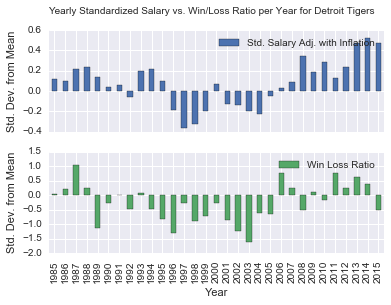

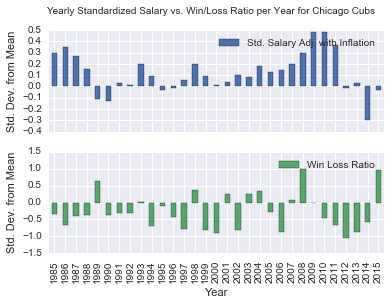

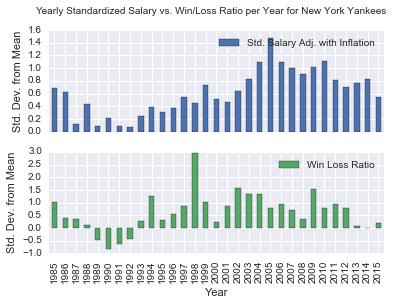

In [427]:
def plot_team_graphs(team_code, team_name):
    team = teams_df.loc[teams_df['teamID'] == team_code]
    merged_salaries_team_data = pd.merge(salaries_df, team, how='inner', on=['yearID', 'teamID'], suffixes=['_l','_r'])

    plot_data = merged_salaries_team_data.groupby(['yearID'])['std_salary_year', 'win_loss_ratio_std'].mean()
    plot = plot_data.plot(kind='bar', subplots=True, title='Yearly Standardized Salary vs. Win/Loss Ratio per Year for '\
    +team_name)
        
    plot[0].set_ylabel('Std. Dev. from Mean')
    plot[0].set_title('')
    plot[0].legend(plot[0].get_legend_handles_labels()[0],['Std. Salary Adj. with Inflation'])
    
    plot[1].set_ylabel('Std. Dev. from Mean')
    plot[1].set_title('')
    plot[1].set_xlabel('Year')
    plot[1].legend(plot[1].get_legend_handles_labels()[0],['Win Loss Ratio'])

#Detroit Tigers   
plot_team_graphs('DET','Detroit Tigers')    

#Chicago Cubs
plot_team_graphs('CHN','Chicago Cubs')

#Toronto Blue Jays
plot_team_graphs('NYA','New York Yankees')

The curves on the graphs all three teams are similar when comparing salaries vs. performance, and they indicate that a better salary could improve the team's performance. However, there are definetly some years where the team's performance improved while the salary had decreased and vice-versa.

To better see if this is true we will due a scatter plot for all teams comparing the performance versus the salary.

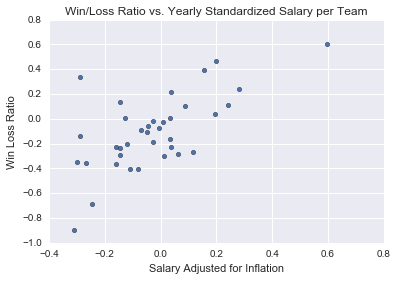

In [428]:
#For all teams
merged_salaries_team_data = pd.merge(salaries_df, teams_df, how='inner', on=['yearID', 'teamID'], suffixes=['_l','_r'])

plot_data1 = merged_salaries_team_data.groupby(['teamID', 'name'])['std_salary_year', 'win_loss_ratio_std'].mean()
plot = plot_data1.plot(kind='scatter', x='std_salary_year', y='win_loss_ratio_std', \
title='Win/Loss Ratio vs. Yearly Standardized Salary per Team')

plot.set_xlabel('Salary Adjusted for Inflation')
plot.set_ylabel('Win Loss Ratio')

The graph above compares the historical data (average of all years available) for the team's performance vs. their salary. And it does indicate a relationship. But the graph below for the team's performance vs. their salary for each year indicate that there is a relationship but it is not that strong.

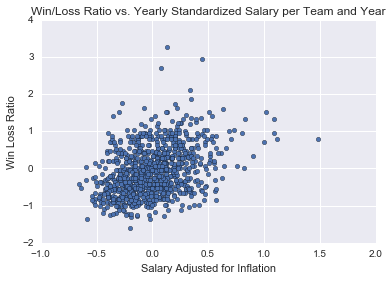

In [429]:
plot_data2 = merged_salaries_team_data.groupby(['yearID','teamID', 'name'])['std_salary_year', 'win_loss_ratio_std'].mean()
plot = plot_data2.plot(kind='scatter', x='std_salary_year', y='win_loss_ratio_std', \
title='Win/Loss Ratio vs. Yearly Standardized Salary per Team and Year')

plot.set_xlabel('Salary Adjusted for Inflation')
plot.set_ylabel('Win Loss Ratio')

The table below presents the top 5 teams by Performance from our historical analysis (the data used on the first scatter plot). The table has the New York Yankees, Los Angeles Angels, Atlanta Braves, Tamba Bay Rays and Boston Red Sox as the best teams. For the exception of the Tampa Bay Rays, all of the other teams have above average performance and above average salaries and are well known for being very good teams.

In [430]:
print plot_data1.sort_values(by=['win_loss_ratio_std','std_salary_year'], ascending=False).head()

                                      std_salary_year  win_loss_ratio_std
teamID name                                                              
NYA    New York Yankees                      0.595288            0.601396
LAA    Los Angeles Angels of Anaheim         0.198811            0.464164
ATL    Atlanta Braves                        0.155458            0.391915
TBA    Tampa Bay Rays                       -0.288605            0.333290
BOS    Boston Red Sox                        0.280917            0.239607


The table below presents the top 5 teams by Performance for each year (the data used on the second scatter plot). All teams on this table have higher than average salaries.

In [431]:
print plot_data2.sort_values(by=['win_loss_ratio_std','std_salary_year'], ascending=False).head()

                                 std_salary_year  win_loss_ratio_std
yearID teamID name                                                  
2001   SEA    Seattle Mariners          0.133778            3.268166
1998   NYA    New York Yankees          0.442763            2.937800
1995   CLE    Cleveland Indians         0.077771            2.707544
1986   NYN    New York Mets             0.336834            2.093530
1998   ATL    Atlanta Braves            0.346376            1.852310


Our hypothesis for this study is that a higher average team salary will influence and improve the team's performance. WIth the analysis that has been done, it is possible to conclude that there is a relationship between salary and performance. The data also shows that this relationship is not perfect and that there are cases where a high salary did not meet the desired outcome of a good performance.

This study is limited by observing just the salary and not exploring other variables which coulde also be important, such as: players age and experience, fan base, coaching quality and others. While the team's average salary is not a deciding factor for the team's performance, better salaries tend to attract good baseball players which could positvely impact the team's success, but this outcome is not guaranteed.